In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Loading the data and looking at the variables

In [2]:
train_main = pd.read_csv("../raw_data/train_main.csv")
train_forecast = pd.read_csv("../raw_data/train_forecast_sales_perf.csv")
train_labels = pd.read_csv("../raw_data/train_label.csv", header=None)

test_main = pd.read_csv("../raw_data/test_main.csv")
test_forecast = pd.read_csv("../raw_data/test_forecast_sales_perf.csv")

C:\Users\axel\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\axel\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Do some renaming and cleaning of the columns name
train_labels = train_labels.rename(columns = {0: "sku", 1: "went_on_backorder"})

train_main = train_main.rename(columns = {'Unnamed: 0':'sku'})
test_main = test_main.rename(columns = {'Unnamed: 0':'sku'})

train_forecast = train_forecast.drop(train_forecast.columns[0], axis=1)
train_forecast = train_forecast.rename(columns = {'variable':'forecast_type'})
test_forecast = test_forecast.drop(test_forecast.columns[0], axis=1)
test_forecast = test_forecast.rename(columns = {'variable':'forecast_type'})

In [4]:
train_main.head()

,sku,national_inv,lead_time,in_transit_qty,min_bank,potential_issue,pieces_past_due,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop
0,1440246,4.0,2.0,0.0,0.0,No,0.0,0.0,No,No,No,Yes,No
1,2805934,29.0,8.0,0.0,1.0,No,0.0,0.0,No,No,No,No,No
2,1478785,32.0,8.0,38.0,38.0,No,0.0,0.0,No,No,No,Yes,No
3,1963250,9.0,14.0,0.0,0.0,No,0.0,0.0,No,No,No,Yes,No
4,1614805,3.0,9.0,0.0,0.0,No,0.0,0.0,No,No,No,Yes,No


In train_main.csv and test_main.csv:

- national_inv - Current inventory level for the part
- lead_time - Transit time for product (if available)
- in_transit_qty - Amount of product in transit from source
- min_bank - Minimum recommend amount to stock
- potential_issue - Source issue for part identified
- pieces_past_due - Parts overdue from source
- local_bo_qty - Amount of stock orders overdue
- deck_risk - Part risk flag
- oe_constraint - Part risk flag
- ppap_risk - Part risk flag
- stop_auto_buy - Part risk flag
- rev_stop - Part risk flag

In [5]:
train_forecast.head()

,sku,forecast_type,value
0,1440246,forecast_3_month,16.0
1,2805934,forecast_3_month,120.0
2,1478785,forecast_3_month,144.0
3,1963250,forecast_3_month,0.0
4,1614805,forecast_3_month,0.0


In train_forecast and test_forecast:

- forecast_3_month - Forecast sales for the next 3 months
- forecast_6_month - Forecast sales for the next 6 months
- forecast_9_month - Forecast sales for the next 9 months
- sales_1_month - Sales quantity for the prior 1 month time period
- sales_3_month - Sales quantity for the prior 3 month time period
- sales_6_month - Sales quantity for the prior 6 month time period
- sales_9_month - Sales quantity for the prior 9 month time period
- perf_6_month_avg - Source performance for prior 6 month period
- perf_12_month_avg - Source performance for prior 12 month period

## Tidy train_forecast and test_forecast

A tidy data set is defined as

1. Each variable forms a column
2. Each observation forms a row
3. Each type of observational unit forms a table

`train_forecast` and `test_forecast` clearly aren't tidy. So let's fix that.

In [6]:
train_forecast_tidy = train_forecast.pivot(index='sku', columns="forecast_type", values='value').reset_index()
test_forecast_tidy = test_forecast.pivot(index='sku', columns="forecast_type", values='value').reset_index()

Note: `NaN` have been introduced. We'll fix that later.

In [7]:
train_forecast_tidy.head()

forecast_type,sku,forecast_3_month,forecast_6_month,forecast_9_month,perf_12_month_avg,perf_6_month_avg,sales_1_month,sales_3_month,sales_6_month,sales_9_month
0,1026827,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,12.0
1,1043384,239.0,459.0,635.0,0.78,0.73,134.0,302.0,537.0,786.0
2,1043696,0.0,0.0,0.0,0.75,0.82,1.0,1.0,1.0,1.0
3,1043852,0.0,0.0,0.0,0.67,0.78,0.0,0.0,4.0,5.0
4,1044048,NaN,40.0,40.0,-99.00,NaN,NaN,0.0,0.0,NaN


##  Convert categorical data to numerical data

In [8]:
train_labels = train_labels.replace({'No': 0, 'Yes': 1})
train_labels.head()

,sku,went_on_backorder
0,1440246,0
1,2805934,0
2,1478785,0
3,1963250,0
4,1614805,0


In [9]:
train_main = train_main.replace({'No': 0, 'Yes': 1})
test_main = test_main.replace({'No': 0, 'Yes': 1})

train_main.head()

,sku,national_inv,lead_time,in_transit_qty,min_bank,potential_issue,pieces_past_due,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop
0,1440246,4.0,2.0,0.0,0.0,0,0.0,0.0,0,0,0,1,0
1,2805934,29.0,8.0,0.0,1.0,0,0.0,0.0,0,0,0,0,0
2,1478785,32.0,8.0,38.0,38.0,0,0.0,0.0,0,0,0,1,0
3,1963250,9.0,14.0,0.0,0.0,0,0.0,0.0,0,0,0,1,0
4,1614805,3.0,9.0,0.0,0.0,0,0.0,0.0,0,0,0,1,0


# Merge train and test data sets

The column name `sku` allows us to merge the data frames into one.

In [10]:
train_labels.shape, train_main.shape, train_forecast_tidy.shape

((1924935, 2), (1924935, 13), (2366933, 10))

In [11]:
test_main.shape, test_forecast_tidy.shape

((5000, 13), (5000, 10))

In [12]:
temp = pd.merge(train_main, train_forecast_tidy, on="sku")
train = pd.merge(temp, train_labels, on="sku")

test = pd.merge(test_main, test_forecast_tidy, on="sku")
train.shape, test.shape

((1531719, 23), (5000, 22))

# Final touch and saving the tidy data

Now that we have merged the data, the `sku` variable is not necessary anymore.

In [13]:
train = train.drop("sku", 1)
test = test.drop("sku", 1)

In [14]:
train.to_csv("../tidy_data/train.csv")
test.to_csv("../tidy_data/test.csv")

# Exploratory data analysis

In [15]:
train.shape

(1531719, 22)

In order to produce some plots in a reasonable time span, `train` will be reduced to 5% of its original size.

In [16]:
train_small = train.dropna().sample(frac=0.05, random_state=42)
train_small.shape

(63897, 22)

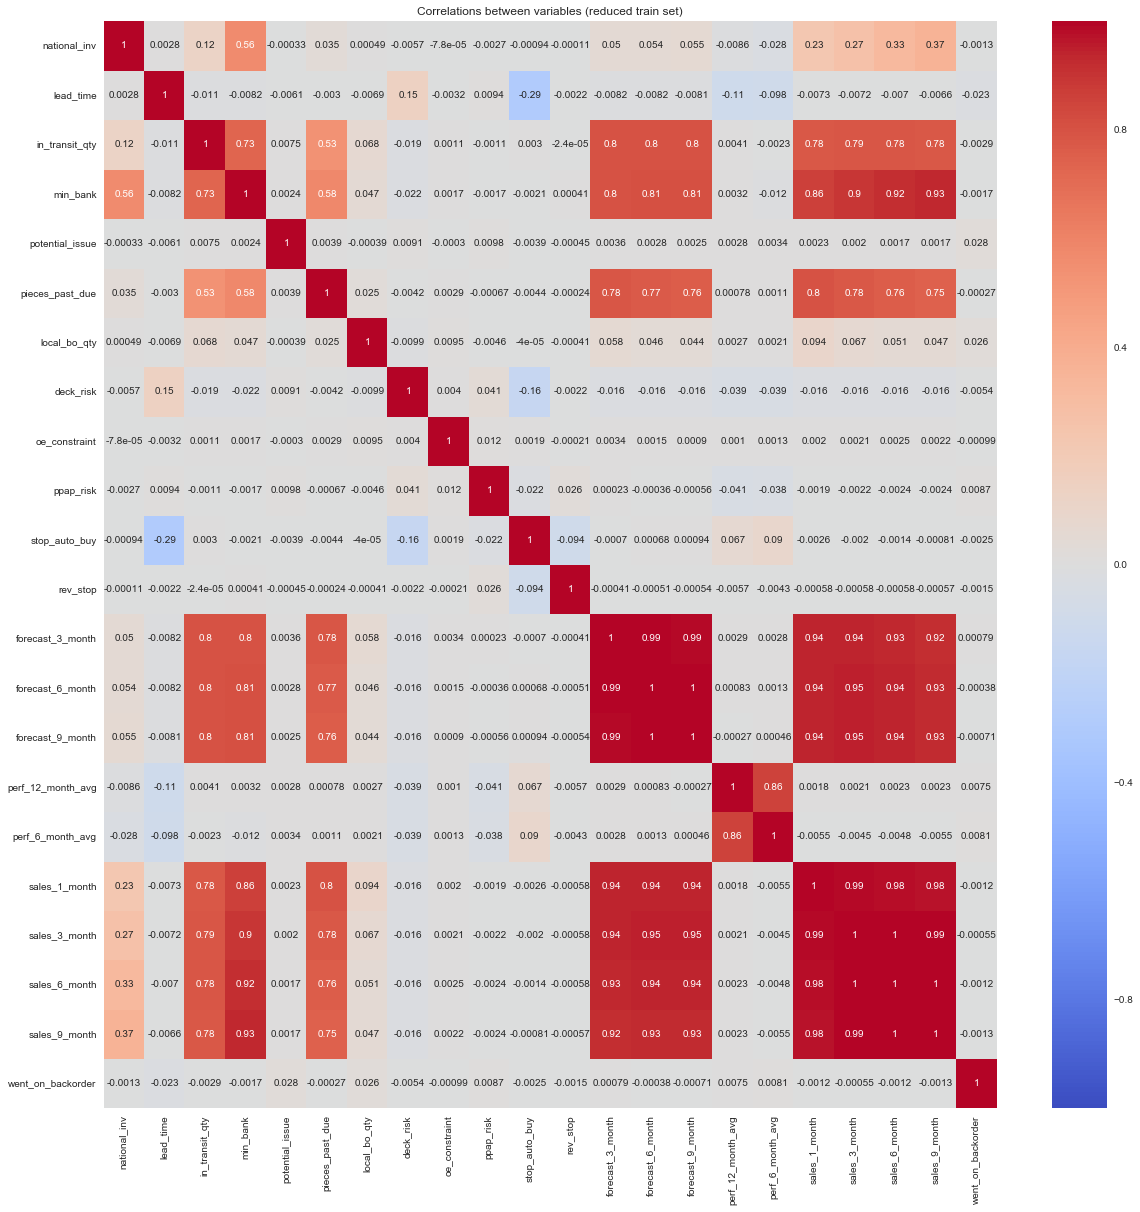

In [17]:
fig, ax = plt.subplots(figsize=(20, 20))
plot = sns.heatmap(train_small.corr(), cmap='coolwarm', annot=True, ax=ax)
ax.set_title('Correlations between variables (reduced train set)')
fig = plot.get_figure()
fig.savefig("../figures/heatmap.png")

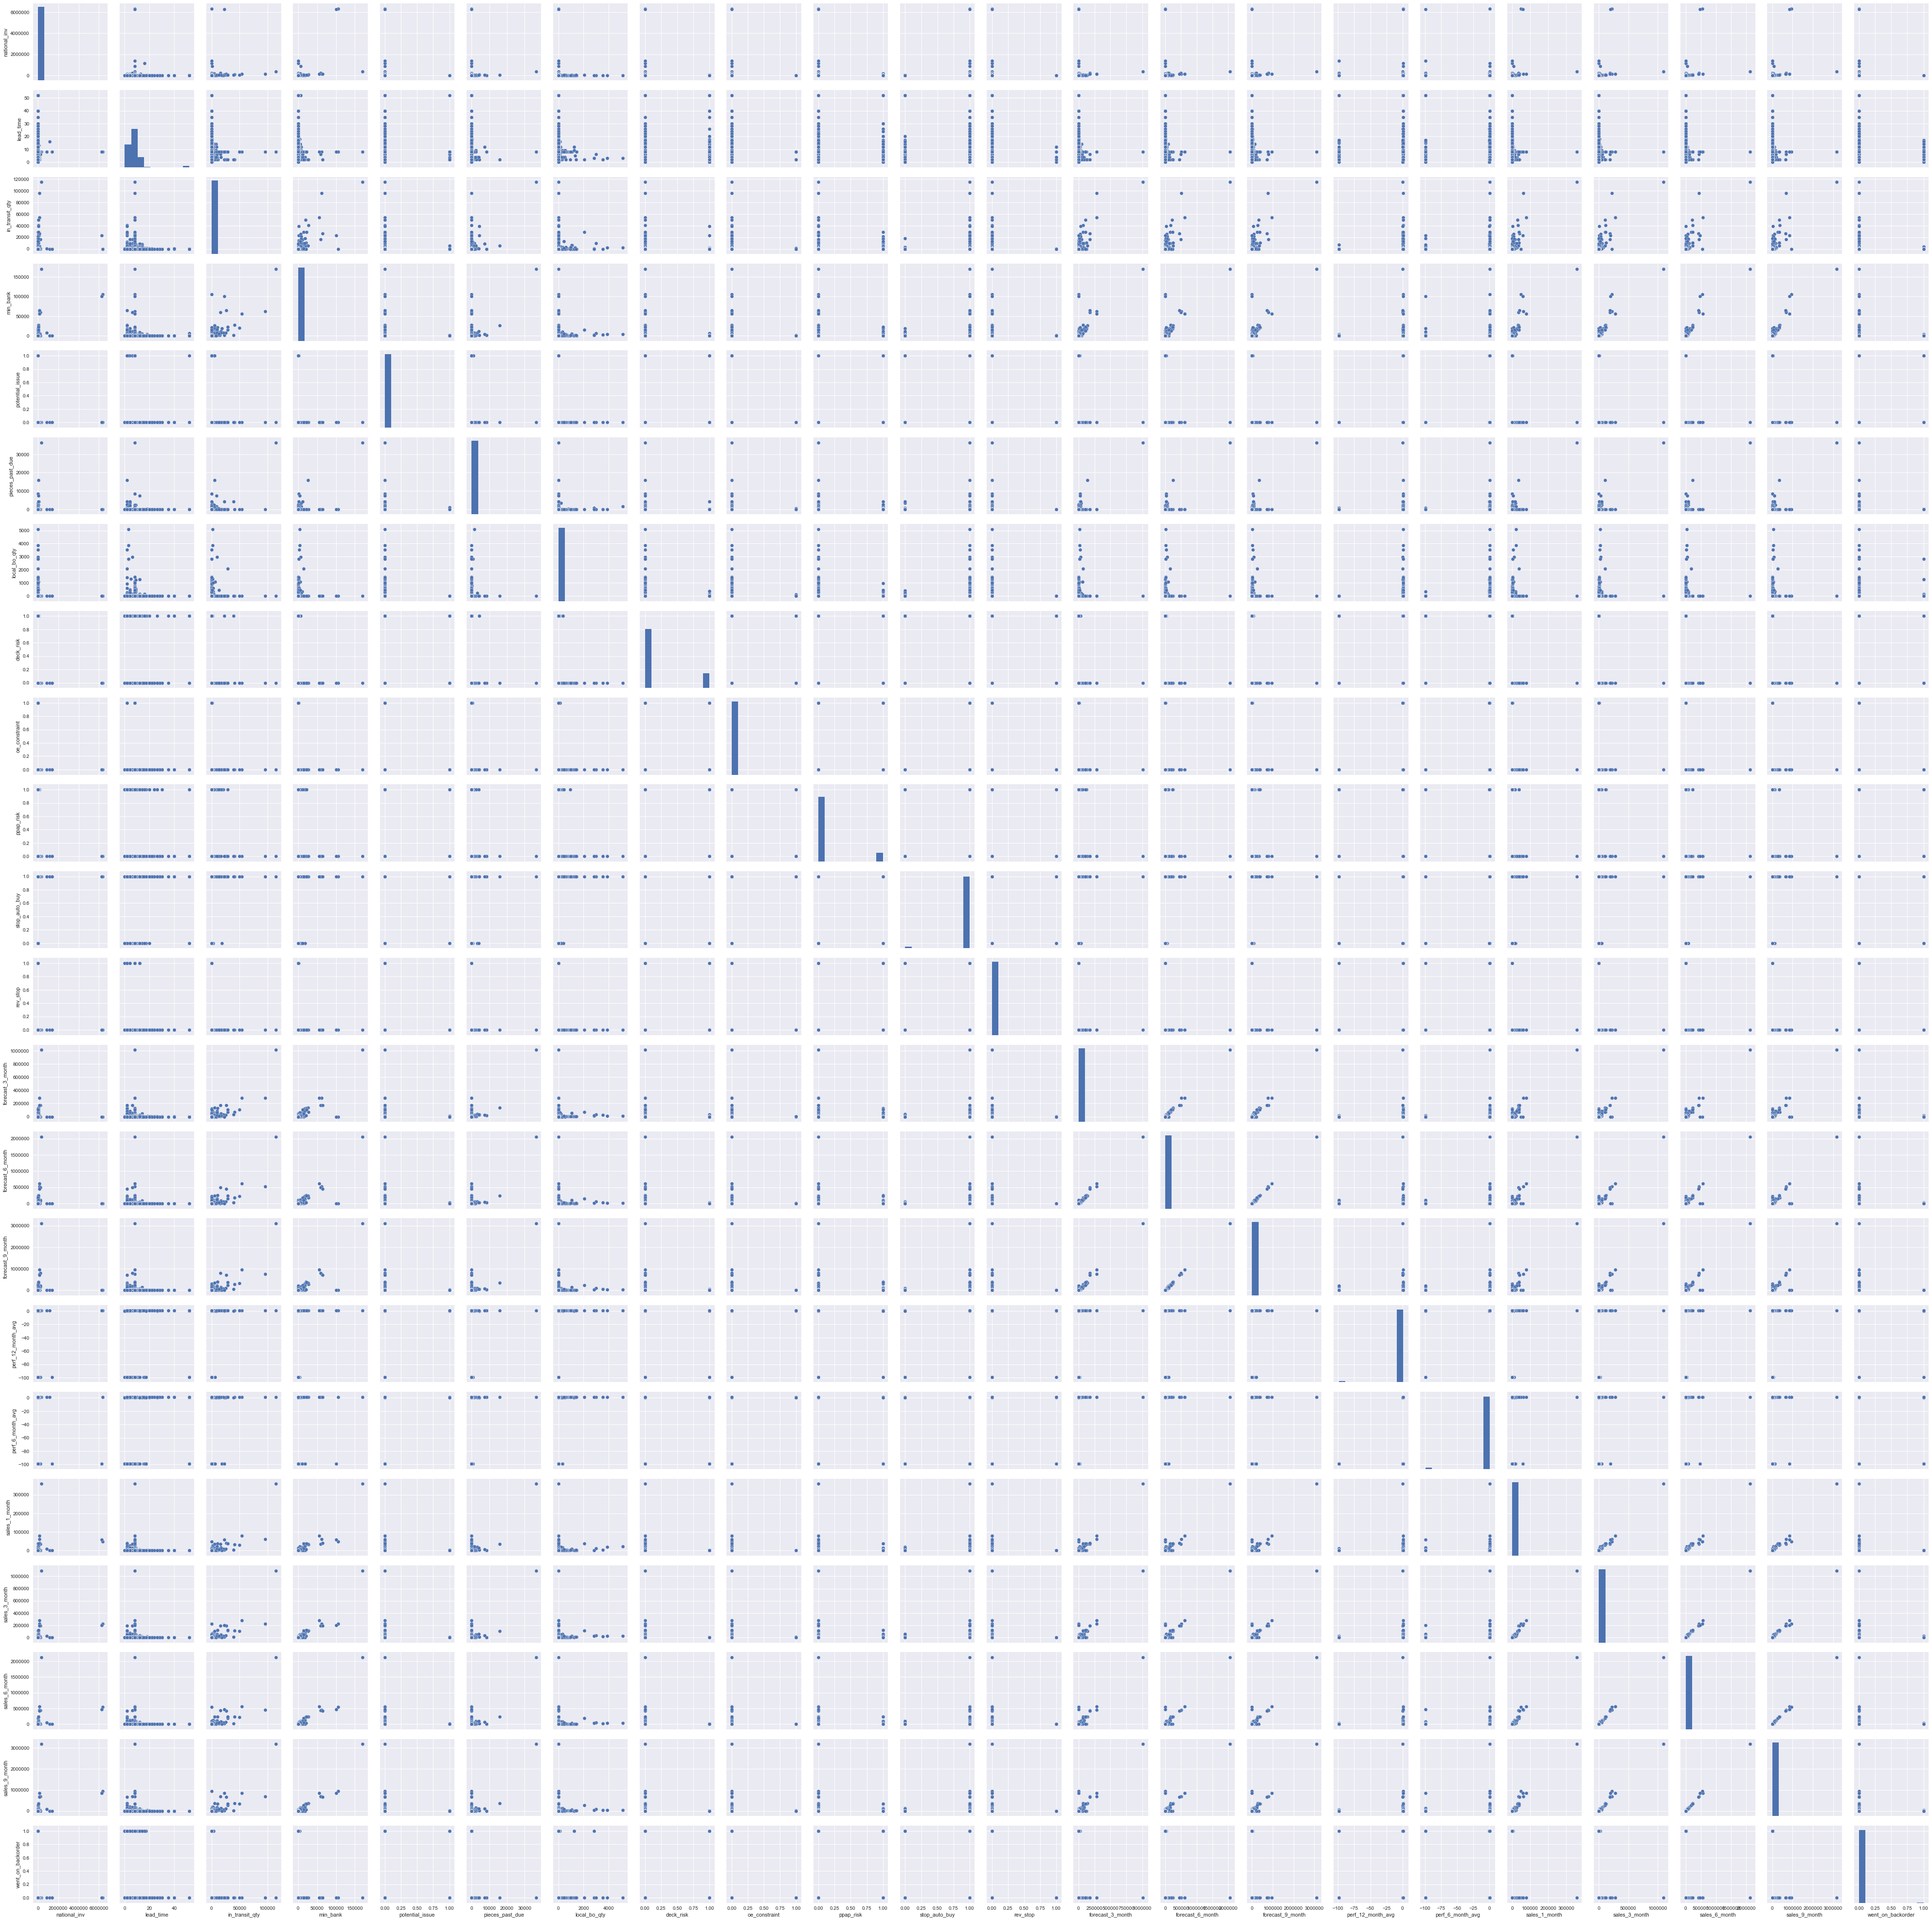

In [18]:
plot = sns.pairplot(train_small)
plot.savefig("../figures/pairplots.png")

From the two plots above, we notice that the `went_on_back_order` (i.e. the target value) is **not** correlated with any variables. Tough times ahead!

In [5]:
test.shape

(5000, 21)

In [6]:
train.shape

(1531719, 22)

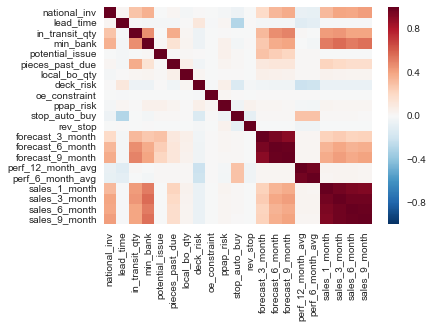

In [12]:
sns.heatmap(test.corr())

In [2]:
train = pd.read_csv("../tidy_data/train.csv", index_col = 0)
test = pd.read_csv("../tidy_data/test.csv", index_col = 0)

C:\Users\axel\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


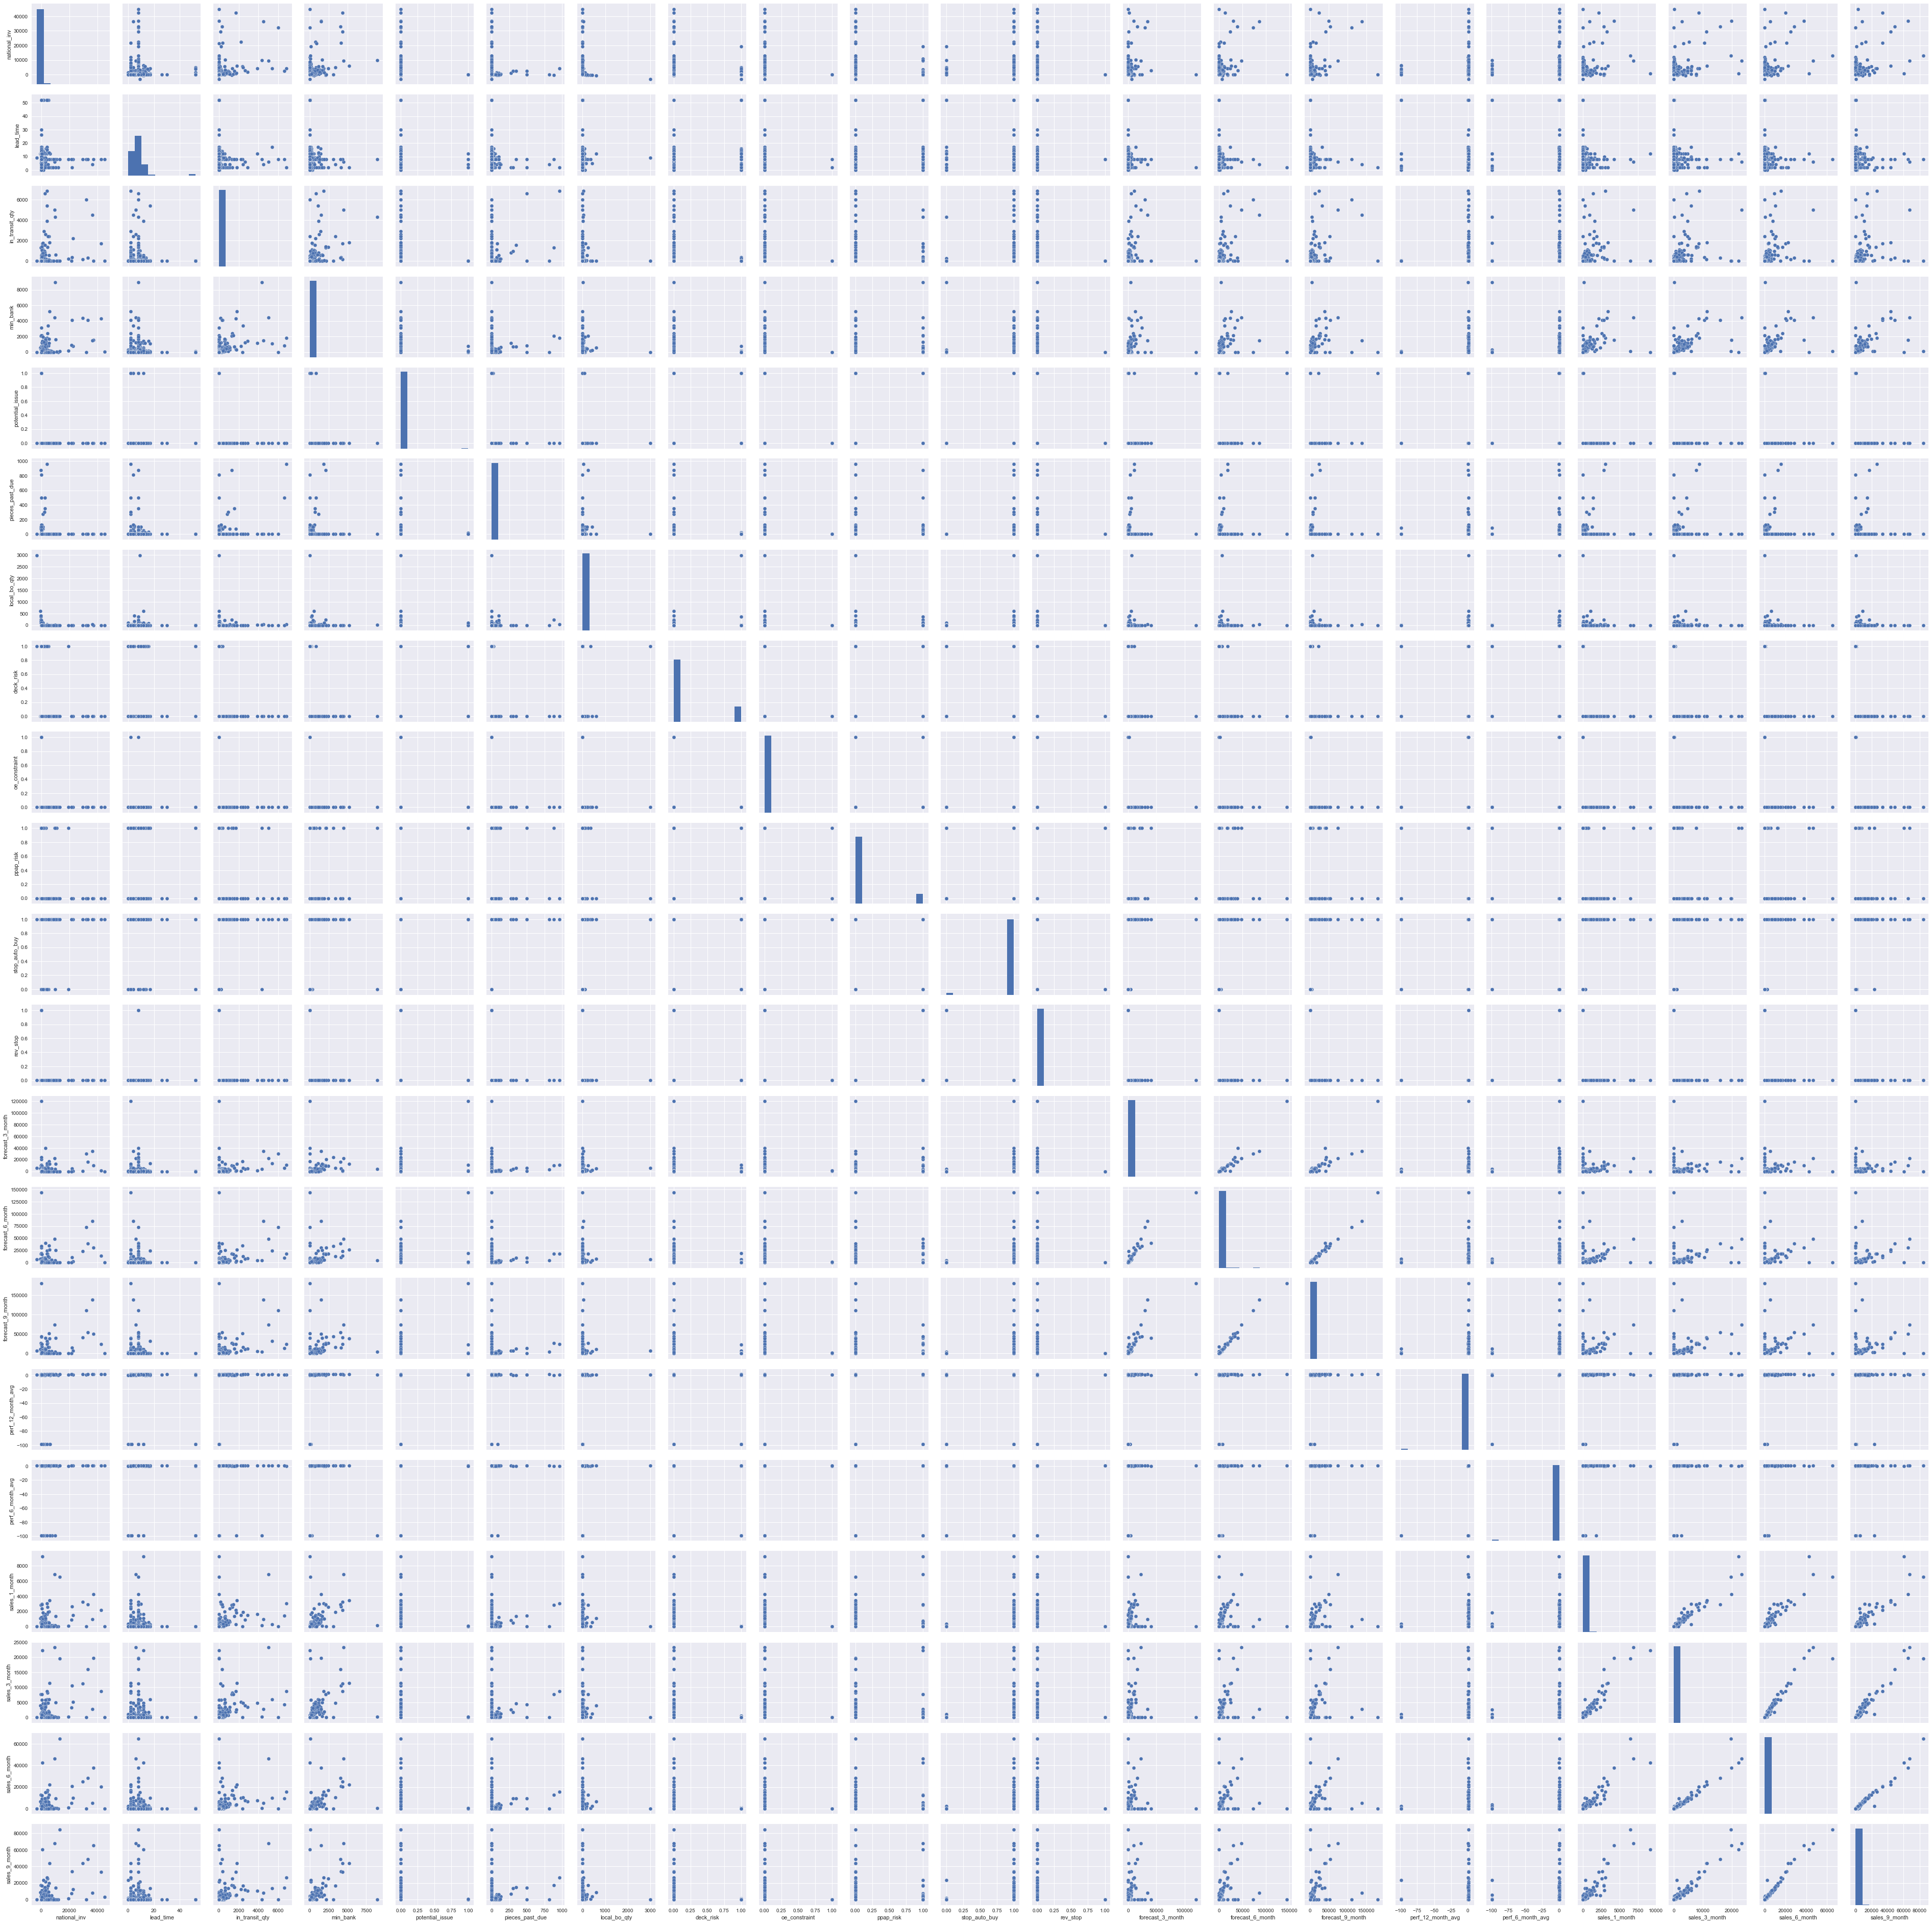

In [14]:
sns.pairplot(test.dropna())

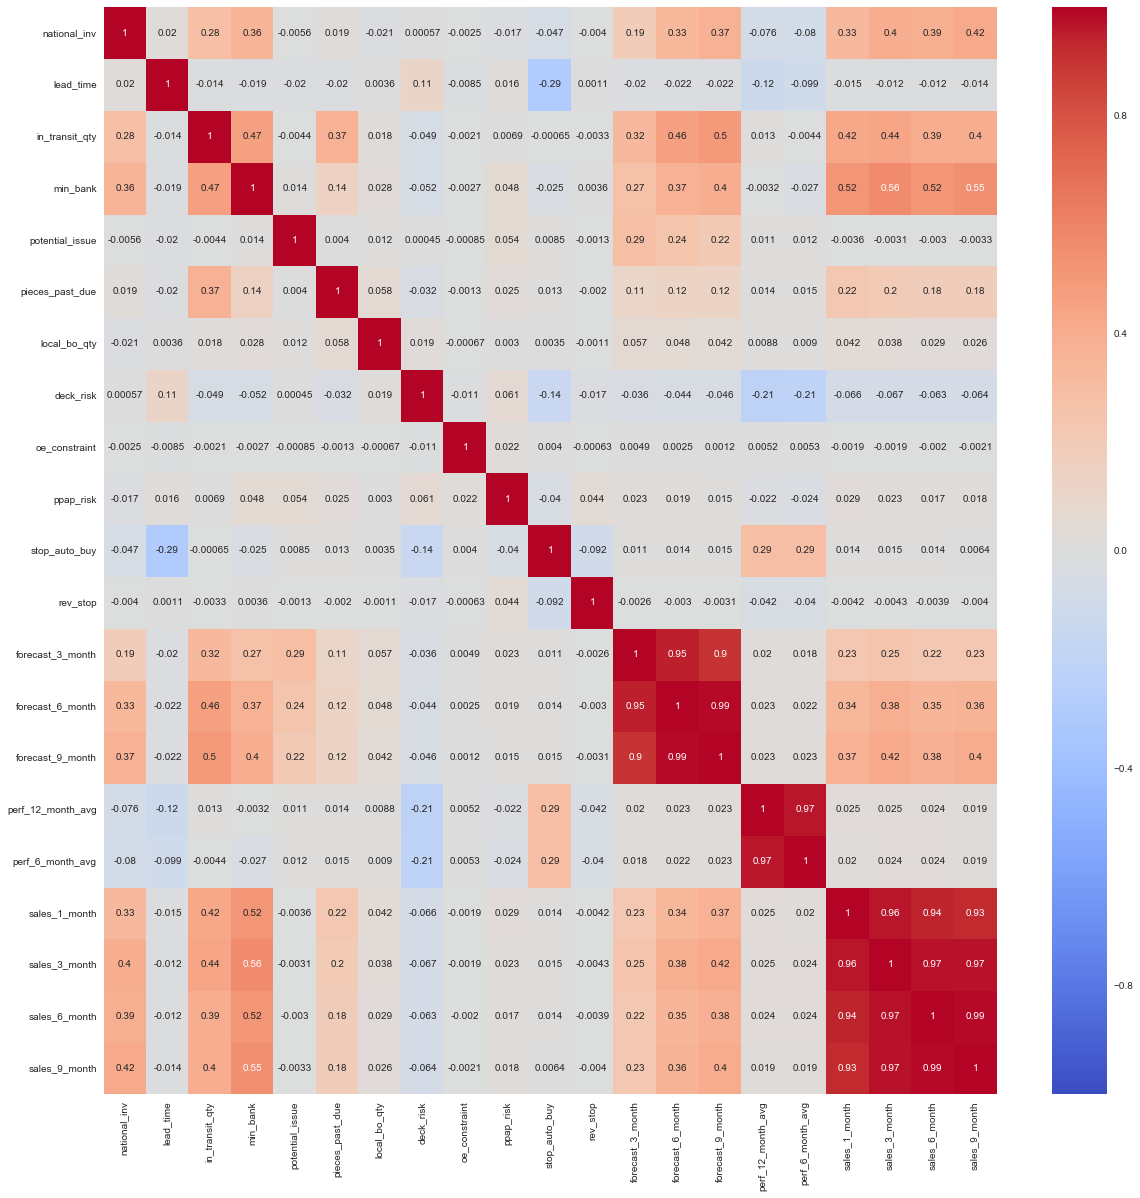

In [4]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(test.corr(), cmap='coolwarm', annot=True, ax=ax)


# How to deal with NaNs - Test data

In [96]:
test.isnull().mean()

sku                  0.000
national_inv         0.000
lead_time            0.056
in_transit_qty       0.000
min_bank             0.000
potential_issue      0.000
pieces_past_due      0.000
local_bo_qty         0.000
deck_risk            0.000
oe_constraint        0.000
ppap_risk            0.000
stop_auto_buy        0.000
rev_stop             0.000
forecast_3_month     0.000
forecast_6_month     0.000
forecast_9_month     0.000
perf_12_month_avg    0.000
perf_6_month_avg     0.000
sales_1_month        0.000
sales_3_month        0.000
sales_6_month        0.000
sales_9_month        0.000
dtype: float64

In [98]:
test.lead_time.describe()

count    4720.000000
mean        7.712076
std         6.547360
min         0.000000
25%         4.000000
50%         8.000000
75%         9.000000
max        52.000000
Name: lead_time, dtype: float64

We can see that `lead_time` has 5% missing values. Also from the `describe()` function, we can see a min value of 0 and a max value of 52. Given those outliers, I chose to impute the missing values with the median rather than the mean.

In [105]:
test["lead_time"] = test["lead_time"].fillna(test["lead_time"].median())

# How to deal with NaNs - Train data

In [109]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 22 columns):
sku                  5000 non-null int64
national_inv         5000 non-null float64
lead_time            5000 non-null float64
in_transit_qty       5000 non-null float64
min_bank             5000 non-null float64
potential_issue      5000 non-null int64
pieces_past_due      5000 non-null float64
local_bo_qty         5000 non-null float64
deck_risk            5000 non-null int64
oe_constraint        5000 non-null int64
ppap_risk            5000 non-null int64
stop_auto_buy        5000 non-null int64
rev_stop             5000 non-null int64
forecast_3_month     5000 non-null float64
forecast_6_month     5000 non-null float64
forecast_9_month     5000 non-null float64
perf_12_month_avg    5000 non-null float64
perf_6_month_avg     5000 non-null float64
sales_1_month        5000 non-null float64
sales_3_month        5000 non-null float64
sales_6_month        5000 non-null float64
sale

In [76]:
train.isnull().mean()

sku                  0.000000
national_inv         0.000000
lead_time            0.059976
in_transit_qty       0.000000
min_bank             0.000000
potential_issue      0.000000
pieces_past_due      0.000000
local_bo_qty         0.000000
deck_risk            0.000000
oe_constraint        0.000000
ppap_risk            0.000000
stop_auto_buy        0.000000
rev_stop             0.000000
forecast_3_month     0.000000
forecast_6_month     0.042786
forecast_9_month     0.064662
perf_12_month_avg    0.044718
perf_6_month_avg     0.033780
sales_1_month        0.004986
sales_3_month        0.042786
sales_6_month        0.054690
sales_9_month        0.009972
went_on_backorder    0.000000
dtype: float64

In [78]:
train.shape

(1531719, 23)

In [79]:
train.dropna().shape

(1277934, 23)

sku                  0.000
national_inv         0.000
lead_time            0.056
in_transit_qty       0.000
min_bank             0.000
potential_issue      0.000
pieces_past_due      0.000
local_bo_qty         0.000
deck_risk            0.000
oe_constraint        0.000
ppap_risk            0.000
stop_auto_buy        0.000
rev_stop             0.000
forecast_3_month     0.000
forecast_6_month     0.000
forecast_9_month     0.000
perf_12_month_avg    0.000
perf_6_month_avg     0.000
sales_1_month        0.000
sales_3_month        0.000
sales_6_month        0.000
sales_9_month        0.000
dtype: float64

In [80]:
test.shape

(5000, 22)

In [81]:
test.dropna().shape

(4720, 22)

In [83]:
train.went_on_backorder.value_counts()

0    1521323
1      10396
Name: went_on_backorder, dtype: int64

In [84]:
train.dropna().went_on_backorder.value_counts()

0    1268957
1       8977
Name: went_on_backorder, dtype: int64

In [95]:
from fancyimpute import KNN

# X is the complete data matrix
# X_incomplete has the same values as X except a subset have been replace with NaN

# Use 3 nearest rows which have a feature to fill in each row's missing features
train_filled_knn = KNN(k=3).complete(train.iloc[:, 1:])

MemoryError: 

,national_inv,lead_time,in_transit_qty,min_bank,potential_issue,pieces_past_due,local_bo_qty,deck_risk,oe_constraint,ppap_risk,...,forecast_3_month,forecast_6_month,forecast_9_month,perf_12_month_avg,perf_6_month_avg,sales_1_month,sales_3_month,sales_6_month,sales_9_month,went_on_backorder
0,4.0,2.0,0.0,0.0,0,0.0,0.0,0,0,0,...,16.0,16.0,32.0,1.00,1.00,2.0,8.0,13.0,18.0,0
1,29.0,8.0,0.0,1.0,0,0.0,0.0,0,0,0,...,120.0,120.0,120.0,0.85,0.85,10.0,19.0,33.0,64.0,0
2,32.0,8.0,38.0,38.0,0,0.0,0.0,0,0,0,...,144.0,144.0,144.0,0.96,0.96,12.0,35.0,60.0,101.0,0
3,9.0,14.0,0.0,0.0,0,0.0,0.0,0,0,0,...,0.0,0.0,0.0,0.38,0.44,0.0,0.0,0.0,1.0,0
4,3.0,9.0,0.0,0.0,0,0.0,0.0,0,0,0,...,0.0,0.0,0.0,0.78,0.70,0.0,0.0,0.0,0.0,0


In [86]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1531719 entries, 0 to 1531718
Data columns (total 23 columns):
sku                  1531719 non-null object
national_inv         1531719 non-null float64
lead_time            1439852 non-null float64
in_transit_qty       1531719 non-null float64
min_bank             1531719 non-null float64
potential_issue      1531719 non-null int64
pieces_past_due      1531719 non-null float64
local_bo_qty         1531719 non-null float64
deck_risk            1531719 non-null int64
oe_constraint        1531719 non-null int64
ppap_risk            1531719 non-null int64
stop_auto_buy        1531719 non-null int64
rev_stop             1531719 non-null int64
forecast_3_month     1531719 non-null float64
forecast_6_month     1466183 non-null float64
forecast_9_month     1432675 non-null float64
perf_12_month_avg    1463223 non-null float64
perf_6_month_avg     1479977 non-null float64
sales_1_month        1524082 non-null float64
sales_3_month        14661

# Problems
# NaNs -> drop or imputation?
# Unbalanced? 
